# <center> FITS Comparison

In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import sys
import math
sys.path.append('..')  # add parent directory to path to import utils
from utils import set_plots_size_params
import pyabc
import os
import scipy.stats as st
import pandas as pd
import subprocess
import time

In [2]:
def wf_with_selection_and_mutation(wt_freq, population_size, fitness, mutation_rate, sequence_sample_size):
    # math from https://academic.oup.com/sysbio/article/66/1/e30/2670014#syw056M2 
    # Note that the order of selectiona and mutation is relevant to the results.
    wt_freq = (wt_freq * fitness) / ( (1-wt_freq) + (wt_freq * fitness))                 # selection
    wt_freq = wt_freq*(1 - mutation_rate) + (1 - wt_freq)*mutation_rate                  # mutation
    wt_freq = np.random.binomial(population_size, wt_freq) / population_size             # bottleneck
    return wt_freq

    
def wt_generations(generations_number, wt_freq, population_size, fitness, mutation_rate, sequence_sample_size, 
                   color=None, label=None, plot=True):
    freqs = [wt_freq]
    for i in range(generations_number-1):
        wt_freq = wf_with_selection_and_mutation(wt_freq=wt_freq, population_size=population_size, 
                                                 fitness=fitness, mutation_rate=mutation_rate, 
                                                 sequence_sample_size=sequence_sample_size)
        freqs.append(wt_freq)
    freqs = np.random.binomial(sequence_sample_size, freqs) / sequence_sample_size   # sequence sampling
    if plot:
        plt.plot(range(generations_number), freqs, color=color, label=label, alpha=0.1)
    return np.array(freqs)


def simulate_50(generations_number, wt_freq, population_size, fitness, mutation_rate, sequence_sample_size, 
                 color=None, label=None, plot=True):
    if plot:
        plt.xlabel('Generation')
        plt.ylabel('Frequency')
    data = []
    for i in range(50):
        datum = wt_generations(generations_number=generations_number, wt_freq=wt_freq, plot=plot,
                               population_size=population_size, fitness=fitness, mutation_rate=mutation_rate, 
                               color=color,  sequence_sample_size=sequence_sample_size, 
                               label=label if i==0 else None)
        data.append(datum)
    if label:
        leg = plt.legend()
        for lh in leg.legendHandles: 
            lh.set_alpha(1)
    return pd.DataFrame(data)

In [3]:
def pyFITS(prior_dist, data, simulation_num, params, top_fraction):
    values = []
    for i in range(simulation_num):
        prior = 10**prior_dist.rvs()['x']
        sym = wt_generations(mutation_rate=prior, generations_number=params['gen'], wt_freq=params['freq0'], 
                             population_size=params['pop'], fitness=params['fit'], 
                             sequence_sample_size=params['ss'], plot=False)
        distance = (abs(sym-data) + abs((1-sym)-(1-data))).sum()  # correction to align with FITS weirdness
        values.append({'distance': distance, 'post': prior})
    df = pd.DataFrame.from_records(values).sort_values('distance')
    df = df.head(int(simulation_num * top_fraction))
    df['log_post'] = np.log10(df['post'])
    return df

def pyFITS_fitness(prior_dist, data, simulation_num, params, top_fraction):
    values = []
    for i in range(simulation_num):
        prior = prior_dist.rvs()['x']
        sym = wt_generations(fitness=prior, mutation_rate=params['mut'], generations_number=params['gen'], 
                             wt_freq=params['freq0'], population_size=params['pop'], 
                             sequence_sample_size=params['ss'], plot=False)
        distance = (abs(sym-data) + abs((1-sym)-(1-data))).sum()  # correction to align with FITS weirdness
        values.append({'distance': distance, 'post': prior})
    df = pd.DataFrame.from_records(values).sort_values('distance')
    df = df.head(int(simulation_num * top_fraction))
    df['log_post'] = df['post']
    return df

In [4]:
def run_pyFITS(prior_dist, data, num_sim, top_fraction, model_params, fitness=False):
    start = time.time()
    if fitness:
        post = pyFITS_fitness(prior_dist, data, num_sim, model_params, top_fraction)
    else:
        post = pyFITS(prior_dist, data, num_sim, model_params, top_fraction)
    print("pyFITS run time ", round(time.time()-start,2))
    print(f"pyFITS Created posterior from {len(post)} results")
    print(f"pyFITS max epsilon: {post.distance.max()}")
    return post

In [5]:
def smc_model(parameters):
    pop_size = 100000000
    gen_num = 10
    sample_size = 100000
    intial_freq = 0
    mutation_rate = 10**parameters['x']
    fitness = 1
    return {'a': wt_generations(generations_number=gen_num,  wt_freq=intial_freq, population_size=pop_size, 
                          mutation_rate=mutation_rate, fitness=fitness, sequence_sample_size=sample_size, 
                          plot=False, color=False, label=False)}


def smc_model_fitness(parameters):
    pop_size = 100000000
    gen_num = 10
    sample_size = 100000
    intial_freq = 0
    mutation_rate = 0.0007
    fitness = parameters['x']
    return {'a': wt_generations(generations_number=gen_num,  wt_freq=intial_freq, population_size=pop_size, 
                          mutation_rate=mutation_rate, fitness=fitness, sequence_sample_size=sample_size, 
                          plot=False, color=False, label=False)}

In [6]:
def plot_smc(smc_out):
    fig, ax = plt.subplots()
    for t in range(smc_out.max_t+1):
        df, w = smc_out.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(
            df, w,
            x="x", ax=ax,
            label="PDF t={}".format(t))
    ax.legend(bbox_to_anchor=(1, 1))
    plt.show()


In [7]:
def last_freq_L1(simulation, data):
    return abs(data['a'] - simulation['a']).sum()

def run_smc(priors, data, epsilon, fitness=False):
    start = time.time()
    if fitness == 1:
        model = smc_model
    elif fitness == 'infer':
        model = smc_model_fitness        
    abc = pyabc.ABCSMC(
            model, priors,
            last_freq_L1, population_size=1000, 
            sampler=pyabc.sampler.SingleCoreSampler())  # limit to a single core to compare results to other models
    db_path = ("sqlite:///test.db")
    smc_post = abc.new(db_path, {'a': data})
    smc_post = abc.run(minimum_epsilon=epsilon, max_nr_populations=10)
    print("SMC run time: ", round(time.time()-start,2))
    print("Total number of SMC simulations: ", smc_post.total_nr_simulations)
    plot_smc(smc_post)
    return smc_post

In [8]:
def plot_kdes(smc_output, pyFITS_output, FITS_output, real_value, fitness=False):
    fig, ax = plt.subplots()
    df, w = smc_output.get_distribution(m=0)
    pyabc.visualization.plot_kde_1d(
        df, w, 
        x="x", ax=ax,
        label="ABCSMC")
    if not fitness:
        real_value = math.log10(real_value)
    ax.axvline(real_value, color="k", linestyle="dashed")
    pyabc.visualization.plot_kde_1d(
        pyFITS_output, np.ones(len(pyFITS_output))/len(pyFITS_output), label='pyFITS', x='log_post', ax=ax)
    pyabc.visualization.plot_kde_1d(
        FITS_output, np.ones(len(FITS_output))/len(FITS_output), label='FITS', x='log', ax=ax)
    plt.title('Posterior')
    plt.legend()
    if fitness:
        plt.xlabel('fitness')
    else:
        plt.xlabel('log mutation rate')
    return fig, ax

In [9]:
def create_fits_input_data(data):
    outfile = 'fits_input_data.tsv'
    fits = dict()
    fits['mut'] = pd.DataFrame(data={'freq': data})
    fits['wt'] = pd.DataFrame(data={'freq': 1-data})
    fits['mut']['allele'] = 1
    fits['wt']['allele'] = 0
    fits_input = pd.concat(fits.values()).reset_index().rename(columns={'index': 'gen'})
    fits_input=fits_input[['gen','allele','freq']]
    fits_input.to_csv(outfile, index=False, sep='\t')
    return outfile
    
def run_FITS(data, params_file=None, fitness=False):
    """FITS params need to be edited manually"""
    input_data_file = create_fits_input_data(data)
    if fitness:
        run_type = 'fitness'
        if not params_file:
            params_file = "../FITS/params_f01_mr734.txt"
    else:
        run_type = 'mutation'
        if not params_file:
            params_file = "../FITS/parameters.txt"
    cmd = f"./../FITS/fits1.3.3 -{run_type} {params_file} {input_data_file} fits_post.tsv fits_sum.txt"
    start = time.time()
    subprocess.run(cmd.split())
    print("FITS run time: ", round(time.time()-start,2))
    fits_post = pd.read_table('fits_post.tsv')
    if fitness:
        fits_post['log'] = fits_post['allele1']
    else:
        fits_post['log'] = np.log10(fits_post['allele0_1'])
    return fits_post

In [10]:
def compare_pyFITS(mutation_rate, prior_edges=[-7,-2], num_sim=100000, top_fraction=0.01, 
                   params_file=None, fitness=1):
    params = {'gen': 10, 'freq0':0, 'pop': 100000000, 'ss': 100000, 'fit': fitness}
    print("Creating dataset...")
    data = simulate_50(generations_number=params['gen'], wt_freq=params['freq0'],  mutation_rate=mutation_rate,
                       population_size=params['pop'], fitness=params['fit'], sequence_sample_size=params['ss'], 
                             plot=False).mean()
    prior_dist = pyabc.Distribution(x=pyabc.RV("uniform", prior_edges[0], prior_edges[1]-prior_edges[0]))
    print("running pyFits...")
    pyfits_out = run_pyFITS(prior_dist, data, num_sim, top_fraction, params)
    print("Running FITS...")
    fits_out = run_FITS(data, params_file)
    print("FITS max distance: ", fits_out['distance'].max())
    print("pyFITS max distance: ", pyfits_out['distance'].max())
    epsilon = pyfits_out['distance'].max()
    print("Running SMC with epsilon: ", epsilon)
    smc_out = run_smc(prior_dist, data, epsilon, fitness)
    return plot_kdes(smc_out, pyfits_out, fits_out, mutation_rate)
    

In [11]:
def compare_fitness_inference(fitness,  num_sim=100000, top_fraction=0.01,  params_file=None, 
                              mutation_rate=0.0007):
    params = {'gen': 10, 'freq0':0, 'pop': 100000000, 'ss': 100000, 'fit': fitness, 'mut': mutation_rate}
    print("Creating dataset...")
    data = simulate_50(generations_number=params['gen'], wt_freq=params['freq0'],  mutation_rate=params['mut'],
                       population_size=params['pop'], fitness=params['fit'], sequence_sample_size=params['ss'], 
                       plot=False).mean()
    prior_dist = pyabc.Distribution(x=pyabc.RV("uniform", 0, 2))
    print("running pyFits...")
    pyfits_out = run_pyFITS(prior_dist, data, num_sim, top_fraction, params, fitness=True)
    print("Running FITS...")
    fits_out = run_FITS(data, params_file, fitness=True)
    print("FITS max distance: ", fits_out['distance'].max())
    print("pyFITS max distance: ", pyfits_out['distance'].max())
    epsilon = pyfits_out['distance'].max()
    print("Running SMC with epsilon: ", epsilon)
    smc_out = run_smc(prior_dist, data, epsilon, fitness='infer')
    return plot_kdes(smc_out, pyfits_out, fits_out, fitness, fitness=True), pyfits_out, fits_out, smc_out, data

# Comparing fitness inference

Creating dataset...
running pyFits...
pyFITS run time  72.87
pyFITS Created posterior from 1000 results
pyFITS max epsilon: 0.0030523999999999196
Running FITS...


INFO:History:Start <ABCSMC(id=201, start_time=2021-02-21 18:32:56.986858, end_time=None)>
INFO:ABC:Calibration sample before t=0.


FITS run time:  2.95
FITS max distance:  0.00311373
pyFITS max distance:  0.0030523999999999196
Running SMC with epsilon:  0.0030523999999999196


INFO:Epsilon:initial epsilon is 0.024214999999999983
INFO:ABC:t: 0, eps: 0.024214999999999983.
INFO:ABC:Acceptance rate: 1000 / 2095 = 4.7733e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.0164842.
INFO:ABC:Acceptance rate: 1000 / 2043 = 4.8948e-01, ESS=9.9191e+02.
INFO:ABC:t: 2, eps: 0.009251673402525296.
INFO:ABC:Acceptance rate: 1000 / 2038 = 4.9068e-01, ESS=9.9928e+02.
INFO:ABC:t: 3, eps: 0.004813726820407671.
INFO:ABC:Acceptance rate: 1000 / 2004 = 4.9900e-01, ESS=9.9670e+02.
INFO:ABC:t: 4, eps: 0.002764826910582518.
INFO:ABC:Acceptance rate: 1000 / 2029 = 4.9285e-01, ESS=9.9134e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=201, start_time=2021-02-21 18:32:56.986858, end_time=2021-02-21 18:33:16.231410)>


SMC run time:  19.29
Total number of SMC simulations:  11209


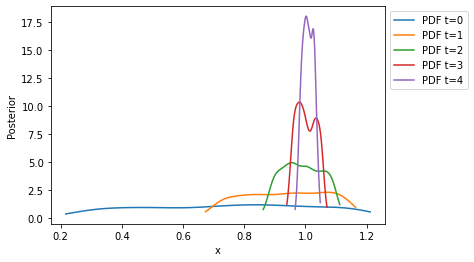

((<Figure size 432x288 with 1 Axes>,
  <AxesSubplot:title={'center':'Posterior'}, xlabel='fitness', ylabel='Posterior'>),
        distance      post  log_post
 25734  0.001018  1.006860  1.006860
 59551  0.001104  1.016819  1.016819
 38547  0.001112  1.004223  1.004223
 15781  0.001128  1.010630  1.010630
 76459  0.001171  1.021701  1.021701
 ...         ...       ...       ...
 87243  0.003048  1.022897  1.022897
 10282  0.003048  1.004773  1.004773
 24951  0.003052  1.017894  1.017894
 51192  0.003052  1.002514  1.002514
 12047  0.003052  1.000965  1.000965
 
 [1000 rows x 3 columns],
      position  distance  allele0   allele1       log
 0         NaN  0.000697        1  1.015680  1.015680
 1         NaN  0.000970        1  1.014320  1.014320
 2         NaN  0.001008        1  1.009400  1.009400
 3         NaN  0.001034        1  1.007080  1.007080
 4         NaN  0.001036        1  0.996704  0.996704
 ..        ...       ...      ...       ...       ...
 995       NaN  0.003110    

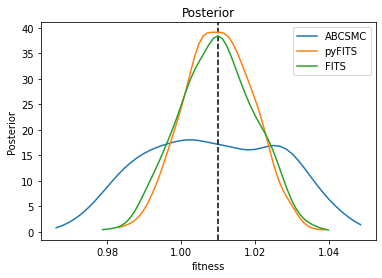

In [12]:
compare_fitness_inference(1.01)

Creating dataset...
running pyFits...
pyFITS run time  76.21
pyFITS Created posterior from 1000 results
pyFITS max epsilon: 0.0032180000000000828
Running FITS...


INFO:History:Start <ABCSMC(id=202, start_time=2021-02-21 18:34:36.933666, end_time=None)>
INFO:ABC:Calibration sample before t=0.


FITS run time:  2.77
FITS max distance:  0.003159
pyFITS max distance:  0.0032180000000000828
Running SMC with epsilon:  0.0032180000000000828


INFO:Epsilon:initial epsilon is 0.02613559999999999
INFO:ABC:t: 0, eps: 0.02613559999999999.
INFO:ABC:Acceptance rate: 1000 / 2051 = 4.8757e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.01788059999999999.
INFO:ABC:Acceptance rate: 1000 / 2078 = 4.8123e-01, ESS=9.9469e+02.
INFO:ABC:t: 2, eps: 0.010140759217639702.
INFO:ABC:Acceptance rate: 1000 / 2037 = 4.9092e-01, ESS=9.9954e+02.
INFO:ABC:t: 3, eps: 0.005361399999999996.
INFO:ABC:Acceptance rate: 1000 / 2037 = 4.9092e-01, ESS=9.9869e+02.
INFO:ABC:t: 4, eps: 0.002821399999999997.
INFO:ABC:Acceptance rate: 1000 / 2022 = 4.9456e-01, ESS=9.9895e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=202, start_time=2021-02-21 18:34:36.933666, end_time=2021-02-21 18:34:54.741525)>


SMC run time:  17.83
Total number of SMC simulations:  11225


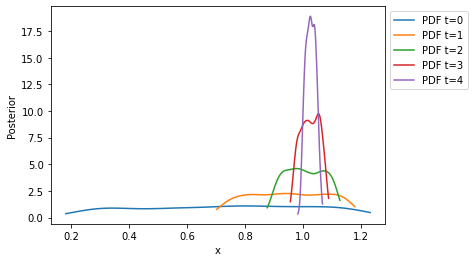

((<Figure size 432x288 with 1 Axes>,
  <AxesSubplot:title={'center':'Posterior'}, xlabel='fitness', ylabel='Posterior'>),
        distance      post  log_post
 38091  0.000814  1.029382  1.029382
 54540  0.000926  1.030452  1.030452
 34207  0.000960  1.028066  1.028066
 9923   0.000984  1.023116  1.023116
 49347  0.000988  1.028368  1.028368
 ...         ...       ...       ...
 53055  0.003216  1.021737  1.021737
 75150  0.003216  1.030886  1.030886
 31626  0.003217  1.046968  1.046968
 66214  0.003218  1.038906  1.038906
 29416  0.003218  1.007525  1.007525
 
 [1000 rows x 3 columns],
      position  distance  allele0  allele1      log
 0         NaN  0.001045        1  1.02968  1.02968
 1         NaN  0.001056        1  1.02668  1.02668
 2         NaN  0.001057        1  1.02395  1.02395
 3         NaN  0.001197        1  1.02649  1.02649
 4         NaN  0.001216        1  1.02953  1.02953
 ..        ...       ...      ...      ...      ...
 995       NaN  0.003155        1  1.02796

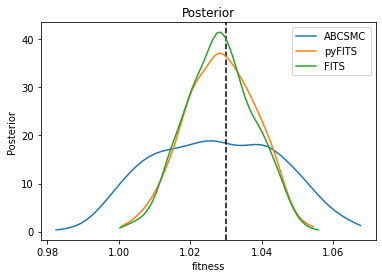

In [13]:
compare_fitness_inference(1.03)

Creating dataset...
running pyFits...
pyFITS run time  74.1
pyFITS Created posterior from 1000 results
pyFITS max epsilon: 0.003795999999999841
Running FITS...


INFO:History:Start <ABCSMC(id=203, start_time=2021-02-21 18:36:13.340136, end_time=None)>
INFO:ABC:Calibration sample before t=0.


FITS run time:  2.75
FITS max distance:  0.00369487
pyFITS max distance:  0.003795999999999841
Running SMC with epsilon:  0.003795999999999841


INFO:Epsilon:initial epsilon is 0.03234
INFO:ABC:t: 0, eps: 0.03234.
INFO:ABC:Acceptance rate: 1000 / 2088 = 4.7893e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.02339599999999999.
INFO:ABC:Acceptance rate: 1000 / 2080 = 4.8077e-01, ESS=9.9723e+02.
INFO:ABC:t: 2, eps: 0.013952986019375523.
INFO:ABC:Acceptance rate: 1000 / 1943 = 5.1467e-01, ESS=9.9879e+02.
INFO:ABC:t: 3, eps: 0.0073410797448337515.
INFO:ABC:Acceptance rate: 1000 / 2058 = 4.8591e-01, ESS=9.9949e+02.
INFO:ABC:t: 4, eps: 0.003569501470158238.
INFO:ABC:Acceptance rate: 1000 / 2058 = 4.8591e-01, ESS=9.9731e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=203, start_time=2021-02-21 18:36:13.340136, end_time=2021-02-21 18:36:32.252778)>


SMC run time:  18.94
Total number of SMC simulations:  11227


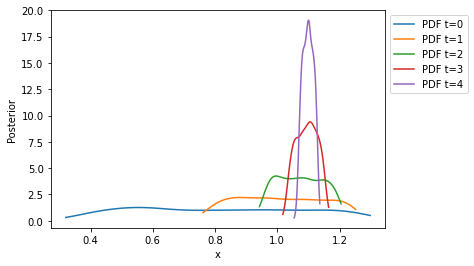

((<Figure size 432x288 with 1 Axes>,
  <AxesSubplot:title={'center':'Posterior'}, xlabel='fitness', ylabel='Posterior'>),
        distance      post  log_post
 598    0.000809  1.108590  1.108590
 99061  0.001056  1.091519  1.091519
 45396  0.001085  1.091109  1.091109
 4328   0.001318  1.098754  1.098754
 12961  0.001349  1.103648  1.103648
 ...         ...       ...       ...
 34206  0.003786  1.088933  1.088933
 89499  0.003792  1.086251  1.086251
 78529  0.003793  1.114715  1.114715
 84175  0.003796  1.101619  1.101619
 34599  0.003796  1.099907  1.099907
 
 [1000 rows x 3 columns],
      position  distance  allele0  allele1      log
 0         NaN  0.001007        1  1.10541  1.10541
 1         NaN  0.001045        1  1.10938  1.10938
 2         NaN  0.001136        1  1.11148  1.11148
 3         NaN  0.001151        1  1.10416  1.10416
 4         NaN  0.001295        1  1.09752  1.09752
 ..        ...       ...      ...      ...      ...
 995       NaN  0.003693        1  1.09517

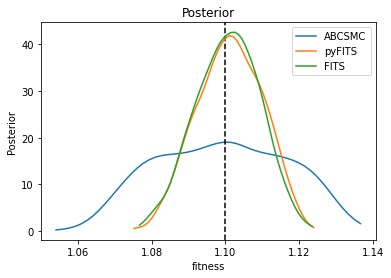

In [14]:
compare_fitness_inference(1.1)

Creating dataset...
running pyFits...
pyFITS run time  74.21
pyFITS Created posterior from 1000 results
pyFITS max epsilon: 0.00592999999999998
Running FITS...


INFO:History:Start <ABCSMC(id=204, start_time=2021-02-21 18:37:51.015265, end_time=None)>
INFO:ABC:Calibration sample before t=0.


FITS run time:  2.75
FITS max distance:  0.00589781
pyFITS max distance:  0.00592999999999998
Running SMC with epsilon:  0.00592999999999998


INFO:Epsilon:initial epsilon is 0.06374499999999998
INFO:ABC:t: 0, eps: 0.06374499999999998.
INFO:ABC:Acceptance rate: 1000 / 1961 = 5.0994e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.04681999999999996.
INFO:ABC:Acceptance rate: 1000 / 2105 = 4.7506e-01, ESS=9.8908e+02.
INFO:ABC:t: 2, eps: 0.025120188606350423.
INFO:ABC:Acceptance rate: 1000 / 1983 = 5.0429e-01, ESS=9.9925e+02.
INFO:ABC:t: 3, eps: 0.012962833247765967.
INFO:ABC:Acceptance rate: 1000 / 2018 = 4.9554e-01, ESS=9.9520e+02.
INFO:ABC:t: 4, eps: 0.006517799999999989.
INFO:ABC:Acceptance rate: 1000 / 2070 = 4.8309e-01, ESS=9.9865e+02.
INFO:ABC:t: 5, eps: 0.0035085999999999898.
INFO:ABC:Acceptance rate: 1000 / 1986 = 5.0352e-01, ESS=9.9926e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=204, start_time=2021-02-21 18:37:51.015265, end_time=2021-02-21 18:38:12.784212)>


SMC run time:  21.79
Total number of SMC simulations:  13123


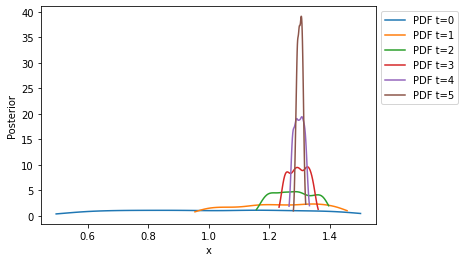

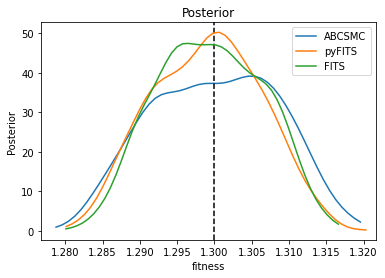

In [15]:
plot, pyfits_out, fits_out, smc_out, data = compare_fitness_inference(1.3)

## Comparing mutation rate inference with fitness = 1

Creating dataset...
running pyFits...
pyFITS run time  72.1
pyFITS Created posterior from 1000 results
pyFITS max epsilon: 0.024797200000000037
Running FITS...


INFO:History:Start <ABCSMC(id=205, start_time=2021-02-21 18:39:34.941212, end_time=None)>
INFO:ABC:Calibration sample before t=0.


FITS run time:  8.12
FITS max distance:  0.0236626
pyFITS max distance:  0.024797200000000037
Running SMC with epsilon:  0.024797200000000037


INFO:Epsilon:initial epsilon is 0.2177908
INFO:ABC:t: 0, eps: 0.2177908.
INFO:ABC:Acceptance rate: 1000 / 2045 = 4.8900e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.1952608.
INFO:ABC:Acceptance rate: 1000 / 2105 = 4.7506e-01, ESS=9.8998e+02.
INFO:ABC:t: 2, eps: 0.1322441066186387.
INFO:ABC:Acceptance rate: 1000 / 2025 = 4.9383e-01, ESS=9.9767e+02.
INFO:ABC:t: 3, eps: 0.07420021307142134.
INFO:ABC:Acceptance rate: 1000 / 1959 = 5.1046e-01, ESS=9.9830e+02.
INFO:ABC:t: 4, eps: 0.039723495297597985.
INFO:ABC:Acceptance rate: 1000 / 1928 = 5.1867e-01, ESS=9.9561e+02.
INFO:ABC:t: 5, eps: 0.01912661757446266.
INFO:ABC:Acceptance rate: 1000 / 1971 = 5.0736e-01, ESS=9.9500e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=205, start_time=2021-02-21 18:39:34.941212, end_time=2021-02-21 18:39:56.772604)>


SMC run time:  21.86
Total number of SMC simulations:  13033


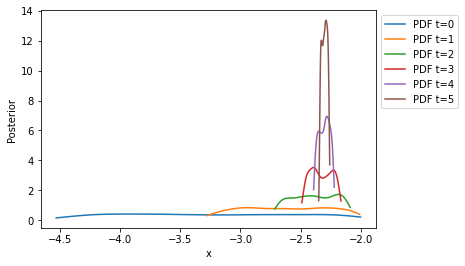

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Posterior'}, xlabel='log mutation rate', ylabel='Posterior'>)

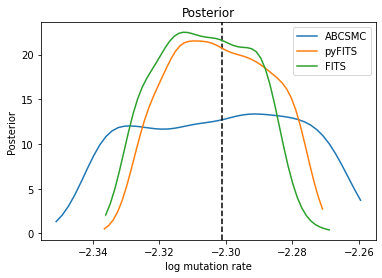

In [16]:
compare_pyFITS(0.005, [-7,-2], 100000, 0.01)

Creating dataset...
running pyFits...
pyFITS run time  71.96
pyFITS Created posterior from 1000 results
pyFITS max epsilon: 0.0010096000000000827
Running FITS...


INFO:History:Start <ABCSMC(id=206, start_time=2021-02-21 18:41:18.879751, end_time=None)>
INFO:ABC:Calibration sample before t=0.


FITS run time:  8.19
FITS max distance:  0.00103886
pyFITS max distance:  0.0010096000000000827
Running SMC with epsilon:  0.0010096000000000827


INFO:Epsilon:initial epsilon is 0.0044548
INFO:ABC:t: 0, eps: 0.0044548.
INFO:ABC:Acceptance rate: 1000 / 2010 = 4.9751e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.0039897999999999965.
INFO:ABC:Acceptance rate: 1000 / 2085 = 4.7962e-01, ESS=9.8468e+02.
INFO:ABC:t: 2, eps: 0.0026687426909775326.
INFO:ABC:Acceptance rate: 1000 / 2126 = 4.7037e-01, ESS=9.9095e+02.
INFO:ABC:t: 3, eps: 0.0014852000000000003.
INFO:ABC:Acceptance rate: 1000 / 2032 = 4.9213e-01, ESS=9.9641e+02.
INFO:ABC:t: 4, eps: 0.0008448220526817901.
INFO:ABC:Acceptance rate: 1000 / 2024 = 4.9407e-01, ESS=9.9491e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=206, start_time=2021-02-21 18:41:18.879751, end_time=2021-02-21 18:41:37.479735)>


SMC run time:  18.62
Total number of SMC simulations:  11277


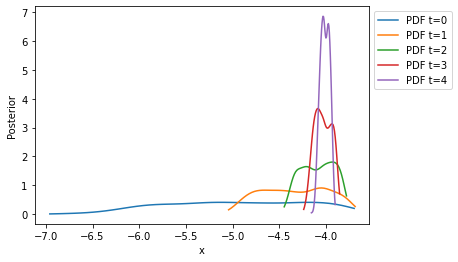

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Posterior'}, xlabel='log mutation rate', ylabel='Posterior'>)

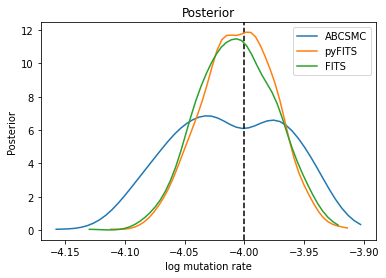

In [17]:
compare_pyFITS(0.0001, [-7,-2], 100000, 0.01)

Creating dataset...
running pyFits...
pyFITS run time  71.48
pyFITS Created posterior from 1000 results
pyFITS max epsilon: 0.0004792000000002286
Running FITS...


INFO:History:Start <ABCSMC(id=207, start_time=2021-02-21 18:42:58.808482, end_time=None)>
INFO:ABC:Calibration sample before t=0.


FITS run time:  8.1
FITS max distance:  0.000479159
pyFITS max distance:  0.0004792000000002286
Running SMC with epsilon:  0.0004792000000002286


INFO:Epsilon:initial epsilon is 0.0013448
INFO:ABC:t: 0, eps: 0.0013448.
INFO:ABC:Acceptance rate: 1000 / 1887 = 5.2994e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.0012148.
INFO:ABC:Acceptance rate: 1000 / 2036 = 4.9116e-01, ESS=9.8330e+02.
INFO:ABC:t: 2, eps: 0.0008448.
INFO:ABC:Acceptance rate: 1000 / 2080 = 4.8077e-01, ESS=9.8827e+02.
INFO:ABC:t: 3, eps: 0.0005048.
INFO:ABC:Acceptance rate: 1000 / 2070 = 4.8309e-01, ESS=9.9671e+02.
INFO:ABC:t: 4, eps: 0.00033719999999999985.
INFO:ABC:Acceptance rate: 1000 / 2265 = 4.4150e-01, ESS=9.8230e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=207, start_time=2021-02-21 18:42:58.808482, end_time=2021-02-21 18:43:17.384144)>


SMC run time:  18.6
Total number of SMC simulations:  11338


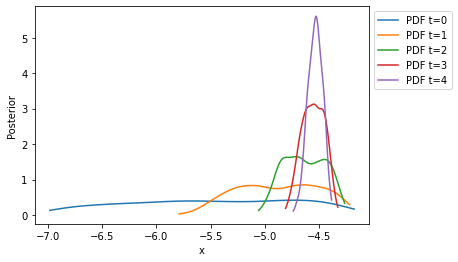

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Posterior'}, xlabel='log mutation rate', ylabel='Posterior'>)

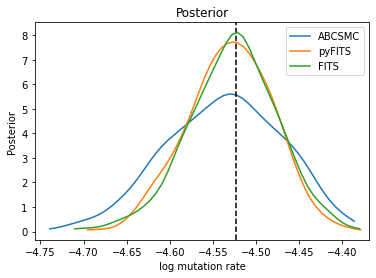

In [18]:
compare_pyFITS(0.00003, [-7,-2], 100000, 0.01)

Creating dataset...
running pyFits...
pyFITS run time  70.46
pyFITS Created posterior from 1000 results
pyFITS max epsilon: 8.960000000017809e-05
Running FITS...


INFO:History:Start <ABCSMC(id=208, start_time=2021-02-21 18:44:38.452665, end_time=None)>
INFO:ABC:Calibration sample before t=0.


FITS run time:  8.86
FITS max distance:  8.87992e-05
pyFITS max distance:  8.960000000017809e-05
Running SMC with epsilon:  8.960000000017809e-05


INFO:Epsilon:initial epsilon is 0.0016301999999999892
INFO:ABC:t: 0, eps: 0.0016301999999999892.
INFO:ABC:Acceptance rate: 1000 / 1976 = 5.0607e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 8.480000000000006e-05.
INFO:ABC:Acceptance rate: 1000 / 1842 = 5.4289e-01, ESS=9.7953e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=208, start_time=2021-02-21 18:44:38.452665, end_time=2021-02-21 18:44:45.194714)>


SMC run time:  6.77
Total number of SMC simulations:  4818


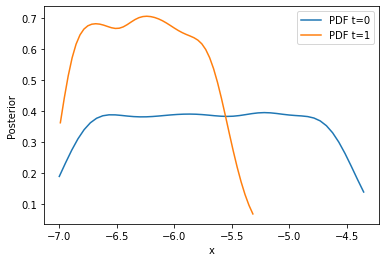

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Posterior'}, xlabel='log mutation rate', ylabel='Posterior'>)

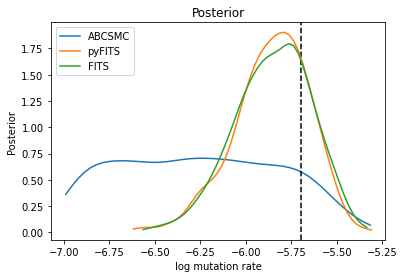

In [19]:
compare_pyFITS(0.000002, [-7,-2], 100000, 0.01)

Creating dataset...
running pyFits...
pyFITS run time  74.85
pyFITS Created posterior from 1000 results
pyFITS max epsilon: 2.4800000000023507e-05
Running FITS...


INFO:History:Start <ABCSMC(id=209, start_time=2021-02-21 18:46:09.419581, end_time=None)>
INFO:ABC:Calibration sample before t=0.


FITS run time:  8.24
FITS max distance:  2.48e-05
pyFITS max distance:  2.4800000000023507e-05
Running SMC with epsilon:  2.4800000000023507e-05


INFO:Epsilon:initial epsilon is 0.0009725999999999964
INFO:ABC:t: 0, eps: 0.0009725999999999964.
INFO:ABC:Acceptance rate: 1000 / 2148 = 4.6555e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 7.04e-05.
INFO:ABC:Acceptance rate: 1000 / 2023 = 4.9432e-01, ESS=9.7112e+02.
INFO:ABC:t: 2, eps: 2.48e-05.
INFO:ABC:Acceptance rate: 1000 / 2003 = 4.9925e-01, ESS=9.7693e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=209, start_time=2021-02-21 18:46:09.419581, end_time=2021-02-21 18:46:19.952891)>


SMC run time:  10.56
Total number of SMC simulations:  7174


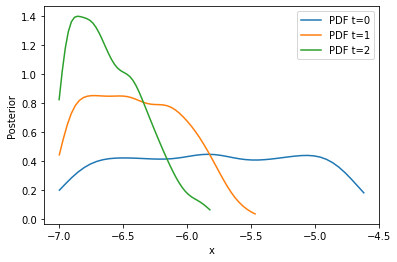

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Posterior'}, xlabel='log mutation rate', ylabel='Posterior'>)

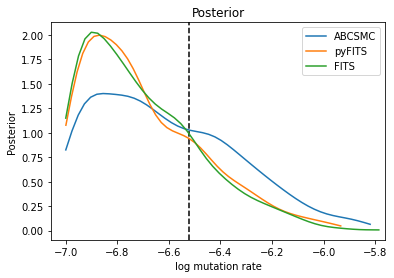

In [20]:
compare_pyFITS(0.0000003, [-7,-2], 100000, 0.01)

In [21]:
THE END!

SyntaxError: invalid syntax (<ipython-input-21-cd9185eb4cf5>, line 1)